In [3]:
import io
#npx degit jghawaly/CSC7809_FoundationModels/Project2/data/raw raw/                             
import os, glob
from typing import Tuple
import numpy as np
import torch
import numpy as np
from functools import reduce
import sentencepiece as spm
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW, lr_scheduler
from torcheval.metrics.metric import Metric
from torcheval.metrics.text import Perplexity, BLEUScore
import json
from tqdm import tqdm
from datetime import datetime
from word_prediction import TokenizedDataset, read_jsonl, add_special_token, training_kit
from models import RNNModel

In [4]:
tokenizer_location = "bptokenizer.model"
training_data = read_jsonl('./data/train.jsonl')
testing_data = read_jsonl('./data/test.jsonl')
sp = spm.SentencePieceProcessor(tokenizer_location)

hidden_size = 128  # Number of hidden units
output_size = sp.GetPieceSize() # Output dimension
seq_len = 30  # Length of the input sequence
batch_size = 256  # Number of sequences in a batch
embed_dim = 1024

In [5]:
def read_jsonl(pat):
    with open(pat, 'r') as f:
        data = [json.loads(line) for line in f]
    return data
def add_special_token(prompt, completion):
    # If the beginning of the prompt is upper case, then we assume it is the start of a sequence
    if prompt[0].isupper():
        prompt = '<bos>' + prompt
    # If the end of the completion is a terminating punctuation, then we assume it is the end of a sequence
    if completion.endswith('.') or completion.endswith('?') or completion.endswith('!'):
        completion += '<eos>'
    return  prompt, completion
    
def mkcollation(pad_id):
    def collate(batch):
        input_batch, target_batch = zip(*batch)
        input_batch = torch.nn.utils.rnn.pad_sequence(input_batch, batch_first=True, padding_value=pad_id)
        target_batch = torch.nn.utils.rnn.pad_sequence(target_batch, batch_first=True, padding_value=pad_id)
        return input_batch, target_batch
    return collate

def evaluate_perplexity(model, perplexity_metric, data_loader, device):
    hidden = model.init_hidden(model.batch_size)
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Initialize hidden state for this batch
            # Forward pass through the model
            logits, hidden = model(inputs, hidden)
            perplexity_metric.update(logits, labels)
            #print(perplexity_metric.compute().item())
    
    # Compute perplexity: torcheval.Perplexity returns exp(avg_loss)
    ppl = perplexity_metric.compute().item()
    return ppl



if torch.cuda.is_available():
    print('torch cuda is_available')
    device = torch.device('cuda')          # Use GPU
else:
    print('torch cuda not is_available')
    device = torch.device('cpu')           # Use CPU
    
metrics = {
    'perp': Perplexity(ignore_index=sp.pad_id()).to(device),
    'bleu': BLEUScore(n_gram=3).to(device)
}


torch cuda is_available


In [6]:
collation = mkcollation(sp.pad_id())
 
training_loader = DataLoader(
    TokenizedDataset(training_data, sp, seq_len),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,

    collate_fn=collation
) 
valset, testset = torch.utils.data.random_split(TokenizedDataset(testing_data, sp, seq_len), [.8, .2])
validation_loader = DataLoader(
    valset,
    drop_last=True,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=collation
)

test_loader = DataLoader(
    testset,
    shuffle=False,
    drop_last=True,
    batch_size=batch_size,
    collate_fn=collation
)

In [7]:
model = RNNModel(embed_dim=embed_dim,
                 hidden_size=hidden_size,
                 output_size=output_size,
                 batch_size=batch_size,
                 n_layers=3,
                 device=device,
                 tokenizer=sp,
                 name="rnn").to(device)
trainkit = training_kit(params=model.parameters(),
                        lr=0.001,
                        weight_decay=0.01,
                        epochs=30,
                        dataloader=training_loader,
                        valloader=validation_loader,
                        batch_size=batch_size)

In [6]:
training_loss, validation_loss = model.reps(trainkit)

  3%|████▊                                                                                                                                             | 1/30 [00:06<03:07,  6.45s/it]

numbers = (avg loss 6.886989407725149 avgval 6.526185290018717 bestval 1000000.0)
patience reset


  7%|█████████▋                                                                                                                                        | 2/30 [00:12<02:54,  6.22s/it]

numbers = (avg loss 6.400496532390644 avgval 6.236425749460856 bestval 6.526185290018717)
patience reset


 10%|██████████████▌                                                                                                                                   | 3/30 [00:18<02:44,  6.11s/it]

numbers = (avg loss 6.068753326093995 avgval 5.881579319636027 bestval 6.236425749460856)
patience reset


 13%|███████████████████▍                                                                                                                              | 4/30 [00:24<02:37,  6.06s/it]

numbers = (avg loss 5.824108517015135 avgval 5.711860990524292 bestval 5.881579319636027)
patience reset


 17%|████████████████████████▎                                                                                                                         | 5/30 [00:30<02:31,  6.05s/it]

numbers = (avg loss 5.69411995194175 avgval 5.610117769241333 bestval 5.711860990524292)
patience reset


 20%|█████████████████████████████▏                                                                                                                    | 6/30 [00:36<02:25,  6.04s/it]

numbers = (avg loss 5.606416355479848 avgval 5.53872226079305 bestval 5.610117769241333)
patience reset


 23%|██████████████████████████████████                                                                                                                | 7/30 [00:42<02:19,  6.08s/it]

numbers = (avg loss 5.54155969619751 avgval 5.486472924550374 bestval 5.53872226079305)
patience reset


 27%|██████████████████████████████████████▉                                                                                                           | 8/30 [00:48<02:13,  6.07s/it]

numbers = (avg loss 5.489155304896367 avgval 5.4400443236033125 bestval 5.486472924550374)
patience reset


 30%|███████████████████████████████████████████▊                                                                                                      | 9/30 [00:54<02:07,  6.08s/it]

numbers = (avg loss 5.443479599890771 avgval 5.402062638600667 bestval 5.4400443236033125)
patience reset


 33%|████████████████████████████████████████████████▎                                                                                                | 10/30 [01:00<02:01,  6.08s/it]

numbers = (avg loss 5.405171047557484 avgval 5.369590584437052 bestval 5.402062638600667)
patience reset


 37%|█████████████████████████████████████████████████████▏                                                                                           | 11/30 [01:07<01:55,  6.09s/it]

numbers = (avg loss 5.372545626256373 avgval 5.344980955123901 bestval 5.369590584437052)
patience reset


 40%|██████████████████████████████████████████████████████████                                                                                       | 12/30 [01:13<01:49,  6.10s/it]

numbers = (avg loss 5.344207859658575 avgval 5.318997859954834 bestval 5.344980955123901)
patience reset


 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 13/30 [01:19<01:44,  6.14s/it]

numbers = (avg loss 5.317975932901556 avgval 5.2993572870890295 bestval 5.318997859954834)
patience reset


 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 14/30 [01:25<01:38,  6.15s/it]

numbers = (avg loss 5.294497527085341 avgval 5.280812295277913 bestval 5.2993572870890295)
patience reset


 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 15/30 [01:31<01:32,  6.16s/it]

numbers = (avg loss 5.272964712861296 avgval 5.265634187062582 bestval 5.280812295277913)
patience reset


 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 16/30 [01:37<01:26,  6.17s/it]

numbers = (avg loss 5.255291347379808 avgval 5.251384083429972 bestval 5.265634187062582)
patience reset


 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 17/30 [01:44<01:20,  6.18s/it]

numbers = (avg loss 5.236911745814534 avgval 5.238362121582031 bestval 5.251384083429972)
patience reset


 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 18/30 [01:50<01:14,  6.22s/it]

numbers = (avg loss 5.2196131960138095 avgval 5.228541994094849 bestval 5.238362121582031)
patience reset


 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 19/30 [01:56<01:08,  6.22s/it]

numbers = (avg loss 5.204919143156572 avgval 5.218876187006632 bestval 5.228541994094849)
patience reset


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 20/30 [02:02<01:02,  6.21s/it]

numbers = (avg loss 5.191319019763501 avgval 5.208753299713135 bestval 5.218876187006632)
patience reset


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 21/30 [02:09<00:55,  6.21s/it]

numbers = (avg loss 5.176088559163081 avgval 5.197479486465454 bestval 5.208753299713135)
patience reset


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 22/30 [02:15<00:49,  6.22s/it]

numbers = (avg loss 5.164645743060421 avgval 5.193452787399292 bestval 5.197479486465454)
patience reset


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 23/30 [02:21<00:43,  6.26s/it]

numbers = (avg loss 5.152820605736275 avgval 5.182745393117269 bestval 5.193452787399292)
patience reset


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 24/30 [02:27<00:37,  6.26s/it]

numbers = (avg loss 5.141551921894024 avgval 5.175314696629842 bestval 5.182745393117269)
patience reset


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 25/30 [02:34<00:31,  6.25s/it]

numbers = (avg loss 5.13089800190616 avgval 5.16932832400004 bestval 5.175314696629842)
patience reset


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 26/30 [02:40<00:25,  6.26s/it]

numbers = (avg loss 5.121647878126665 avgval 5.162790473302206 bestval 5.16932832400004)
patience reset


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 27/30 [02:46<00:18,  6.26s/it]

numbers = (avg loss 5.111646450959243 avgval 5.157644160588583 bestval 5.162790473302206)
patience reset


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 28/30 [02:52<00:12,  6.27s/it]

numbers = (avg loss 5.10239077233649 avgval 5.151652860641479 bestval 5.157644160588583)
patience reset


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 29/30 [02:59<00:06,  6.30s/it]

numbers = (avg loss 5.093950132270912 avgval 5.145278437932332 bestval 5.151652860641479)
patience reset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [03:05<00:00,  6.19s/it]

numbers = (avg loss 5.084674088985889 avgval 5.142538324991862 bestval 5.145278437932332)
patience reset


In [9]:
import matplotlib as plt
import matplotlib.pyplot as plt

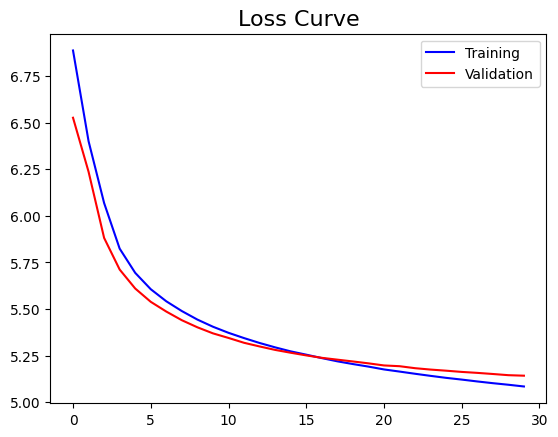

In [10]:
plt.plot(training_loss, color='b', label='Training')
plt.plot(validation_loss, color='r', label="Validation")
plt.title("Loss Curve", size=16)
plt.legend()

In [8]:
model.load_state_dict(torch.load('./good/model_20250330_182906_rnn.torch'))

<All keys matched successfully>

In [11]:
model.eval()
ppl = evaluate_perplexity(model, metrics['perp'], test_loader, device)
print("perplexity", ppl)

print(model.prompt('Which do you prefer? Dogs or cats?', argm=False))

perplexity 168.78354691315644
i shall be able to be seen in his own, but the whole of the state, and i had to go in the house and the old man who, and he had a little of them, i have been a great man, and the most


In [12]:
print(model.prompt('Who is Alice?', argm=False))

he was a little of the same day of a certain of the world. and i was sure, and i have been in the same time. he was not able to do you, and he had been seen in the same way. and, i
